
# Traces synchronization

This example demonstrates how to synchronize a stream of traces using the
:func:`~covseisnet.stream.NetworkStream.synchronize` method. This method finds
the latest start time and the earliest end time among the traces in the
stream, and interpolates the traces between these times with a common sampling
interval. More information about the method can be found in the documentation.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import covseisnet as csn

## Read waveforms

This section reads an example stream of seismic data, which is shipped with
ObsPy. The stream contains three traces, which are highpass at a very high
frequency to see more details in the synchronization.



In [2]:
# Read the example stream (shipped with ObsPy)
stream = csn.read()

# Highpass filter the stream to better see the sync in high frequencies
stream.filter("highpass", freq=1)

# Cut the stream out of the tapering
stream.cut("2009-08-24T00:20:20", duration=0.3)


# Print the original stream
print(stream)

3 Trace(s) in NetworkStream (synced):
BW.RJOB..EHZ | 2009-08-24T00:20:20.000000Z - 2009-08-24T00:20:20.300000Z | 100.0 Hz, 31 samples
BW.RJOB..EHN | 2009-08-24T00:20:20.000000Z - 2009-08-24T00:20:20.300000Z | 100.0 Hz, 31 samples
BW.RJOB..EHE | 2009-08-24T00:20:20.000000Z - 2009-08-24T00:20:20.300000Z | 100.0 Hz, 31 samples


## Desynchronize

This first section desynchronizes the traces in the stream, in order to
demonstrate the synchronization method from the example stream. The traces
are shifted in time by different amounts, and a small number of samples are
collected for visualization.



In [3]:
# Add a random shift to the traces (seeded for reproducibility)
np.random.seed(42)
for trace in stream:
    trace.stats.starttime += np.random.uniform(-0.005, 0.005)

# Print the desynchronized stream
print(stream)

3 Trace(s) in NetworkStream (not synced):
BW.RJOB..EHZ | 2009-08-24T00:20:19.998745Z - 2009-08-24T00:20:20.298745Z | 100.0 Hz, 31 samples
BW.RJOB..EHN | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.304507Z | 100.0 Hz, 31 samples
BW.RJOB..EHE | 2009-08-24T00:20:20.002320Z - 2009-08-24T00:20:20.302320Z | 100.0 Hz, 31 samples


## Synchronize

We now synchronize the traces in the stream using the
:func:`~covseisnet.stream.NetworkStream.synchronize` method. The method
finds the latest start time and the earliest end time among the traces in
the stream, and aligns the traces to these times with interpolation.



In [4]:
# Synchronize the traces
processed_stream = stream.copy()
processed_stream.synchronize(interpolation_method="cubic")

# Print the synchronized stream
print(processed_stream)

3 Trace(s) in NetworkStream (synced):
BW.RJOB..EHZ | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.294507Z | 100.0 Hz, 30 samples
BW.RJOB..EHN | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.294507Z | 100.0 Hz, 30 samples
BW.RJOB..EHE | 2009-08-24T00:20:20.004507Z - 2009-08-24T00:20:20.294507Z | 100.0 Hz, 30 samples


## Compare traces

The synchronized traces are plotted alongside the original traces to compare
the effect of the synchronization method. Note that several interpolation
methods are available in the synchronization method. Check the documentation
for more information.



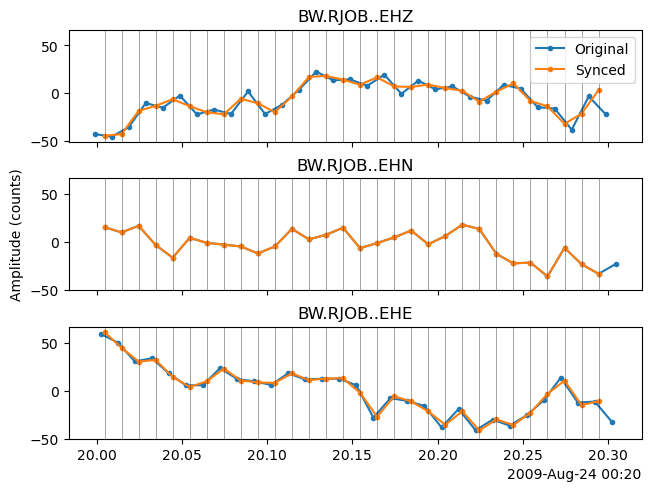

In [5]:
# Create figure
fig, axes = plt.subplots(3, sharex=True, sharey=True, constrained_layout=True)

# Loop over traces
for trace, synced, ax in zip(stream, processed_stream, axes):

    # Plot traces
    ax.plot(trace.times("matplotlib"), trace.data, ".-", label="Original")
    ax.plot(synced.times("matplotlib"), synced.data, ".-", label="Synced")

    # Local settings
    ax.set_title(trace.id)
    for time in synced.times("matplotlib"):
        ax.axvline(time, color="k", lw=0.5, alpha=0.5)

# Labels
axes[0].legend(loc="upper right")
axes[1].set_ylabel("Amplitude (counts)")

# Date formatting
csn.plot.dateticks(axes[-1])